# Scott Breitbach
## 16-Oct-2021
## DSC630, Assignment 7.2: Create Optimal Hotel Recommendations

1) Start by doing some exploratory analysis of this data to help understand how to make a prediction on the hotel cluster the user is likely to select.  
2) Then, split train.csv into a training and test set (feel free to select a smaller random subset of train.csv).  
3) Then, build at least two prediction models from the training set, and report the accuracies on the test set.   


# Exploratory Data Analysis

In [2]:
# Load Libraries
import numpy as np
import pandas as pd
import random
random.seed(42)

Get a random sample of size *s*:

In [2]:
%%time
# Load a random subset of rows from the data set
file = '../Week7/expedia-hotel-recommendations/train.csv'

# n = 37670293 # number of records in file
n = sum(1 for line in open(file)) - 1
s = 100000 # desired sample size
# skip = sorted(random.sample(range(n), n-s))
skip = sorted(random.sample(range(1, n+1), n-s))
# colNames = pd.read_csv(file, nrows=1).columns
# ranDF = pd.read_csv(file, skiprows=skip, names=colNames)
ranDF = pd.read_csv(file, skiprows=skip)

Wall time: 1min 26s


In [3]:
# Drop any rows containing null values
ranDF.dropna(axis=0, inplace=True)

Get an idea of what the data set looks like:

In [4]:
ranDF.shape

(63935, 24)

In [5]:
ranDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63935 entries, 0 to 99996
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  63935 non-null  object 
 1   site_name                  63935 non-null  int64  
 2   posa_continent             63935 non-null  int64  
 3   user_location_country      63935 non-null  int64  
 4   user_location_region       63935 non-null  int64  
 5   user_location_city         63935 non-null  int64  
 6   orig_destination_distance  63935 non-null  float64
 7   user_id                    63935 non-null  int64  
 8   is_mobile                  63935 non-null  int64  
 9   is_package                 63935 non-null  int64  
 10  channel                    63935 non-null  int64  
 11  srch_ci                    63935 non-null  object 
 12  srch_co                    63935 non-null  object 
 13  srch_adults_cnt            63935 non-null  int

In [6]:
ranDF.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
1,2014-05-15 18:30:52,2,3,66,260,19022,7311.9666,8252,0,1,...,1,1,468,1,0,1,3,48,153,26
2,2014-09-22 14:13:18,2,3,66,153,50542,761.0443,15632,0,1,...,1,1,8805,1,0,1,4,8,120,52
3,2014-12-28 12:36:25,2,3,66,220,43026,4703.5435,23234,0,0,...,0,1,8859,1,0,1,2,50,212,55
4,2014-08-13 13:41:21,2,3,66,348,48862,341.2798,23569,0,0,...,0,1,8287,1,0,2,2,198,397,9


Go through each variable to look at distributions:

In [7]:
# Get counts of values for categories
ranDF.user_location_region.value_counts()

174    10436
348     4223
354     3767
442     3523
220     3331
       ...  
301        1
364        1
460        1
382        1
479        1
Name: user_location_region, Length: 203, dtype: int64

Plot histograms

In [3]:
# Load Libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Set up chart style
sns.set_style("whitegrid")

# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

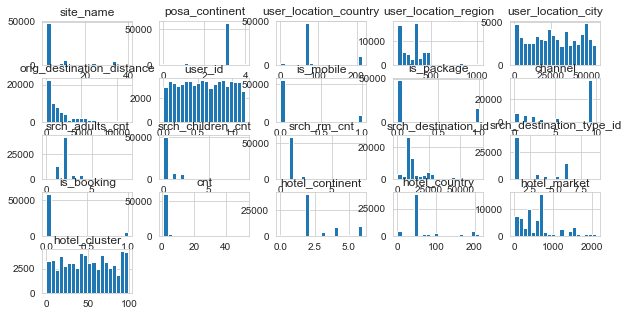

In [10]:
# plot histograms
hist = ranDF.hist(bins=20)

In [11]:
# Function for plotting a histogram, given column and dataframe
def makeHistogram(var, df=ranDF):
    # Create a histogram from a DataFrame variable
    plt.hist(df[var], bins=40)
    plt.xlabel(var, fontsize=20)
    plt.ylabel('Counts', fontsize=20)
    plt.tick_params(axis='both', labelsize=15)
    plt.show()

In [12]:
# %%time
# # Plot each variable in the dataframe
# for i in colNames:
#     makeHistogram(i)

Even though they are all represented numerically, the majority of features are categorical and will need to be treated as such. Many have one dominant value so I may convert those to binary in an effort to even them out.

In [13]:
# Get list of date formatted columns
datCols = ['date_time', 'srch_ci', 'srch_co']

# Get list of categorical variable columns
catCols = ['site_name', 'posa_continent', 'user_location_country', 
           'user_location_region', 'user_location_city', 'user_id', 
           'channel', 'srch_destination_id', 'srch_destination_type_id', 
           'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster']

# Get list of continuous variable columns
numCols = ['orig_destination_distance', 'srch_adults_cnt', 'srch_children_cnt', 
           'srch_rm_cnt', 'cnt']
           
# List of yes/no binary variable columns
ynCols = ['is_mobile', 'is_package', 'is_booking']

Chart categorical variables (boxplot)

In [14]:
# %%time
# # Set up chart style
# sns.set_style("whitegrid")

# # Make box plots for each categorical variable
# plt.rcParams.update({'figure.max_open_warning': 0}) # eliminate warning
# for variable in catCols:
#     plt.figure()
#     sns.boxplot(x = variable, y = 'hotel_cluster', data = ranDF)

Chart binary variables (boxplot)

In [15]:
# %%time
# # Set up chart style
# sns.set_style("whitegrid")

# # Make box plots for each binary variable
# plt.rcParams.update({'figure.max_open_warning': 0}) # eliminate warning
# for variable in ynCols:
#     plt.figure()
#     sns.boxplot(x = variable, y = 'hotel_cluster', data = ranDF)

Chart datetime variables (scatter)

In [16]:
# %%time
# # Make scatter plots for each datetime variable
# for variable in datCols:
#     plt.scatter(x= variable, y = 'hotel_cluster', data = ranDF)
#     plt.xlabel(variable)
#     plt.ylabel('Hotel Cluster')
#     plt.show()

Chart numerical variables (scatter)

In [17]:
# %%time
# # Make scatter plots for each numerical variable
# for variable in numCols:
#     plt.scatter(x= variable, y = 'hotel_cluster', data = ranDF)
#     plt.xlabel(variable)
#     plt.ylabel('Hotel Cluster')
#     plt.show()

Boxplots and scatter plots against the target variable weren't that useful because 'hotel_cluster' is a categorical variable.

Look for correlations using bivariate distribution plots

<timed exec>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Wall time: 2.17 s


<Figure size 720x360 with 0 Axes>

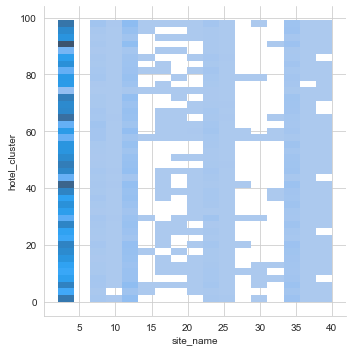

<Figure size 720x360 with 0 Axes>

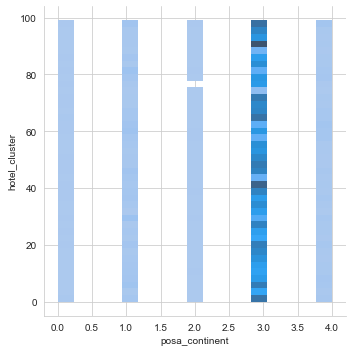

<Figure size 720x360 with 0 Axes>

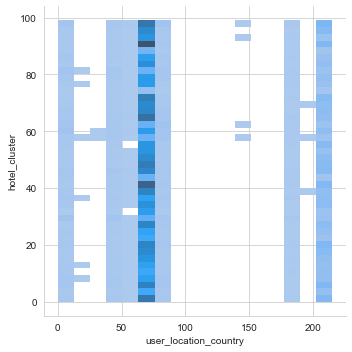

<Figure size 720x360 with 0 Axes>

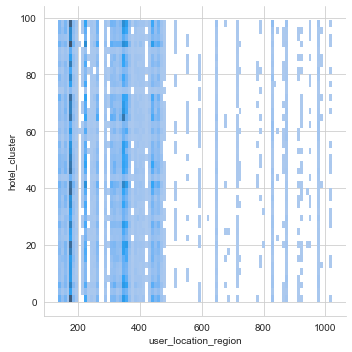

<Figure size 720x360 with 0 Axes>

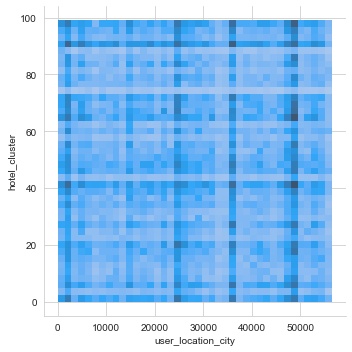

<Figure size 720x360 with 0 Axes>

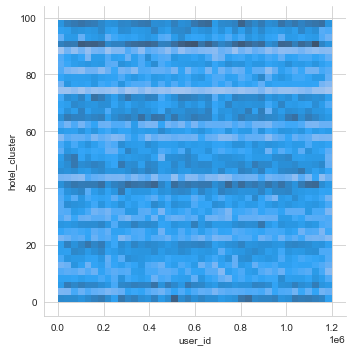

<Figure size 720x360 with 0 Axes>

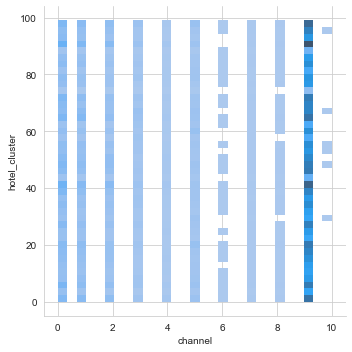

<Figure size 720x360 with 0 Axes>

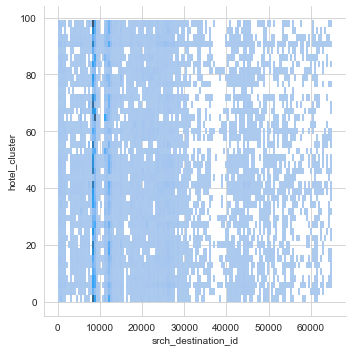

<Figure size 720x360 with 0 Axes>

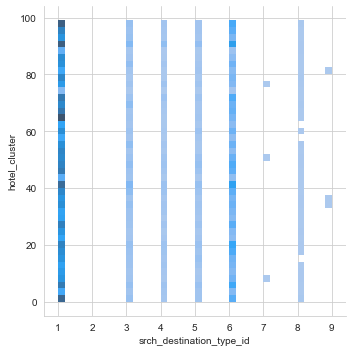

<Figure size 720x360 with 0 Axes>

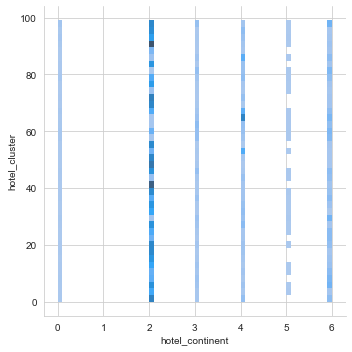

<Figure size 720x360 with 0 Axes>

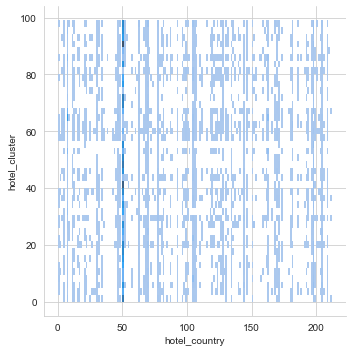

<Figure size 720x360 with 0 Axes>

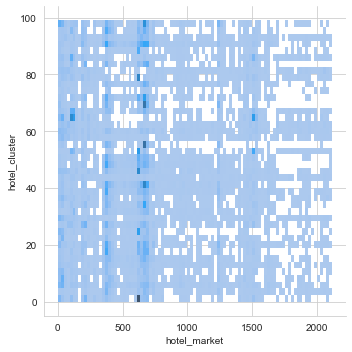

<Figure size 720x360 with 0 Axes>

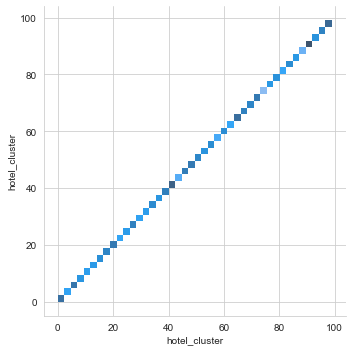

In [18]:
%%time
# Plot bivariate distributions
for variable in catCols:
    plt.figure()
    sns.displot(x = variable, y = 'hotel_cluster', data = ranDF)

Again, we're dealing with uneven distributions. So, while this is slightly better, it doesn't provide much more information.

## Features

Time to manually go through each variable and make transformations:  
* date_time: Add Day of Week / Month of Year
* site_name: Make binary (2 or not 2)
* posa_continent: Make binary (3 or not 3)
* user_location_country: Make binary 66 or not 66 (note: 15% of data was 205)
* user_location_region: Group everything that's >500? (note: 146 unique regions)
  * Binning might be preferred
* ?bin? user_location_city: Leave for now (1814 unique vals 😯)
  * Binning might be preferred
* ?xform? orig_destination_distance: Leave for now
  * Skews right; Consider transforming
* user_id: Ignore for modeling
  * Could potentially use counts of user instances
* is_mobile: Binary, leave as is
* is_package: Binary, leave as is
* channel: Leave for now
  * Could make binary (9 or not 9)
* srch_ci / srch_co: Create Day of Week columns and 'length_of_stay'
* srch_adults_cnt: Leave as is
* srch_children_cnt: Leave as is
* srch_rm_cnt: Leave as is
* srch_destination_id: Leave as is
  * Binning might be preferred
* srch_destination_type_id: Leave as is
* is_booking: Binary, leave as is
* cnt: Leave as is
  * Skews right; Consider transforming
* hotel_continent: Leave as is
  * Could make binary (2 or not 2)
* hotel_country: Make binary (50 or not 50)
* hotel_market: Leave as is
  * Binning might be preferred
* hotel_cluster: TARGET VARIABLE

In [19]:
# Save data
ranDF.to_csv('ranDF.csv', index=False)

In [20]:
# change data types
def change_dtype(cols, to_dtype, df=ranDF):
    for col in cols:
        df[col] = df[col].astype(to_dtype)

In [21]:
# Reassign some data types
change_dtype(catCols, 'category', ranDF)
change_dtype(ynCols, 'int8', ranDF)
change_dtype(datCols, 'datetime64', ranDF)

In [22]:
# Converts a column to binary based on matching / not matching value
def cat_to_binary(row, col, val):
    if row[col] == val:
        return 1
    return 0

In [23]:
# Converts anything over a particular value to that value
def bin_vals(row, col, val):
    if row[col] > val:
        return val
    return row[col]

In [24]:
# Data Transformations and new feature creation
ranDF['date_time_DoW'] = ranDF.date_time.dt.day_name()
ranDF['date_time_MoY'] = ranDF.date_time.dt.month_name()
ranDF['site_name_2'] = ranDF.apply(lambda row: cat_to_binary(row, 'site_name', 2), axis=1)
ranDF['posa_continent_3'] = ranDF.apply(lambda row: cat_to_binary(row, 'posa_continent', 3), axis=1)
ranDF['user_location_country_66'] = ranDF.apply(lambda row: cat_to_binary(row, 'user_location_country', 66), axis=1)
ranDF['user_location_region'] = ranDF.apply(lambda row: bin_vals(row, 'user_location_region', 500), axis=1)
ranDF['srch_ci_DoW'] = ranDF.srch_ci.dt.day_name()
ranDF['srch_co_DoW'] = ranDF.srch_co.dt.day_name()
ranDF['length_of_stay'] = (ranDF['srch_co'] - ranDF['srch_ci'])
ranDF['hotel_country'] = ranDF.apply(lambda row: cat_to_binary(row, 'hotel_country', 50), axis=1)

### Create Dummy Variables

In [25]:
def getDummies(df):
    '''Creates dummy variables from categorical variables, adds them
    to the dataframe and returns the new dataframe with dummy vars'''
    dummyDF = df.copy()
    catList = dummyDF.select_dtypes(include=['object']).columns.tolist()
    for i in catList:
        dummies = pd.get_dummies(dummyDF[i], prefix=i)
        dummyDF = pd.concat([dummyDF, dummies], axis=1)
    return dummyDF

In [26]:
# Create dataframe with dummy variables
ranDF = getDummies(ranDF)
ranDF.shape

(63935, 65)

Reorder columns

In [27]:
# Reorder / select columns
newColOrder = ['date_time_DoW', 'date_time_MoY', 'site_name_2', 'posa_continent_3',
       'user_location_country_66', 'user_location_region',
       'user_location_city', 'orig_destination_distance', 'is_mobile',
       'is_package', 'channel', 'srch_ci_DoW', 'srch_co_DoW', 'length_of_stay',
       'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 
       'date_time_DoW_Friday', 'date_time_DoW_Monday',
       'date_time_DoW_Saturday', 'date_time_DoW_Sunday',
       'date_time_DoW_Thursday', 'date_time_DoW_Tuesday',
       'date_time_DoW_Wednesday', 'date_time_MoY_April',
       'date_time_MoY_August', 'date_time_MoY_December',
       'date_time_MoY_February', 'date_time_MoY_January', 'date_time_MoY_July',
       'date_time_MoY_June', 'date_time_MoY_March', 'date_time_MoY_May',
       'date_time_MoY_November', 'date_time_MoY_October',
       'date_time_MoY_September', 'srch_ci_DoW_Friday', 'srch_ci_DoW_Monday',
       'srch_ci_DoW_Saturday', 'srch_ci_DoW_Sunday', 'srch_ci_DoW_Thursday',
       'srch_ci_DoW_Tuesday', 'srch_ci_DoW_Wednesday', 'srch_co_DoW_Friday',
       'srch_co_DoW_Monday', 'srch_co_DoW_Saturday', 'srch_co_DoW_Sunday',
       'srch_co_DoW_Thursday', 'srch_co_DoW_Tuesday', 'srch_co_DoW_Wednesday',
              'hotel_cluster']
ranDF = ranDF[newColOrder]
ranDF.shape

(63935, 58)

In [28]:
# Look at variables
ranDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63935 entries, 0 to 99996
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   date_time_DoW              63935 non-null  object         
 1   date_time_MoY              63935 non-null  object         
 2   site_name_2                63935 non-null  int64          
 3   posa_continent_3           63935 non-null  int64          
 4   user_location_country_66   63935 non-null  int64          
 5   user_location_region       63935 non-null  int64          
 6   user_location_city         63935 non-null  category       
 7   orig_destination_distance  63935 non-null  float64        
 8   is_mobile                  63935 non-null  int8           
 9   is_package                 63935 non-null  int8           
 10  channel                    63935 non-null  category       
 11  srch_ci_DoW                63935 non-null  object     

In [29]:
# Change category dtype to int64
catList = ranDF.select_dtypes(include=['category']).columns.tolist()
change_dtype(catList, 'int64', ranDF)

# Convert length of stay to integer
ranDF['length_of_stay'] = pd.to_numeric(ranDF['length_of_stay'].dt.days, downcast='integer')

#### Get features that correlate with the target variable

In [30]:
# Look at correlations
dfCorr = ranDF.corr()
dfCorr

,site_name_2,posa_continent_3,user_location_country_66,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,length_of_stay,...,srch_ci_DoW_Tuesday,srch_ci_DoW_Wednesday,srch_co_DoW_Friday,srch_co_DoW_Monday,srch_co_DoW_Saturday,srch_co_DoW_Sunday,srch_co_DoW_Thursday,srch_co_DoW_Tuesday,srch_co_DoW_Wednesday,hotel_cluster
site_name_2,1.000000,0.550232,0.909819,-0.039021,-0.053745,-0.120939,0.023922,-0.009434,-0.030856,-0.079849,...,-0.004099,0.006968,-0.002681,-0.012771,0.001376,0.022403,-0.003400,-0.006434,-0.004422,0.026387
posa_continent_3,0.550232,1.000000,0.497543,-0.211536,-0.009932,-0.164843,0.030411,-0.033772,0.057196,-0.090488,...,-0.011813,0.005100,-0.007674,0.001271,-0.002480,0.018364,-0.000171,-0.009264,-0.005463,0.004251
user_location_country_66,0.909819,0.497543,1.000000,-0.078623,-0.072133,-0.130842,0.028624,-0.003354,-0.043541,-0.083393,...,-0.004715,0.004115,-0.004671,-0.012092,0.003291,0.023947,-0.005220,-0.006599,-0.005286,0.024729
user_location_region,-0.039021,-0.211536,-0.078623,1.000000,0.137233,0.051812,-0.007414,0.030517,-0.012149,0.031450,...,-0.002200,-0.002524,0.002083,-0.001136,0.011513,-0.011928,-0.002225,0.003405,0.000525,0.008161
user_location_city,-0.053745,-0.009932,-0.072133,0.137233,1.000000,0.016545,-0.010662,0.011002,0.012065,0.009198,...,-0.000804,-0.002424,0.004246,0.003064,-0.000112,-0.010442,-0.004186,0.007288,0.003131,-0.006463
orig_destination_distance,-0.120939,-0.164843,-0.130842,0.051812,0.016545,1.000000,-0.060699,0.038749,0.004763,0.226762,...,0.044598,0.020895,0.029257,0.000262,-0.005438,-0.113237,0.038263,0.041839,0.045247,0.001684
is_mobile,0.023922,0.030411,0.028624,-0.007414,-0.010662,-0.060699,1.000000,0.033998,-0.045193,0.006068,...,-0.006511,-0.000781,-0.008335,-0.005181,0.003862,0.014226,0.001901,0.000465,-0.011119,0.012630
is_package,-0.009434,-0.033772,-0.003354,0.030517,0.011002,0.038749,0.033998,1.000000,0.006050,0.333209,...,0.004200,0.036952,0.031311,-0.013089,0.034334,-0.063788,0.026709,-0.002122,0.000897,0.047047
channel,-0.030856,0.057196,-0.043541,-0.012149,0.012065,0.004763,-0.045193,0.006050,1.000000,-0.016222,...,0.005610,0.007722,0.012687,-0.000897,-0.007218,-0.005078,0.004395,-0.002022,-0.000107,0.002599
length_of_stay,-0.079849,-0.090488,-0.083393,0.031450,0.009198,0.226762,0.006068,0.333209,-0.016222,1.000000,...,0.010249,0.012682,0.049344,-0.003287,0.025439,-0.091352,0.017577,0.014293,0.010644,0.038766


Correlations are really low. Get a list of the most highly correlated.

In [31]:
# Get a list of variables with > 0.01 correlation
hiCorr = dfCorr['hotel_cluster'][abs(dfCorr['hotel_cluster']) > 0.01]
# Convert to a sorted list by highest correlation
hiCorrList = abs(hiCorr).sort_values(ascending=False).index.to_list()
# Remove target variable from list
hiCorrList = hiCorrList[1:]

#### Get a list of best variables using Feature Selection

In [4]:
# Load libraries
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Select numerical columns

In [33]:
# Reorder / select columns
numCols = ['site_name_2', 'posa_continent_3',
       'user_location_country_66', 'user_location_region',
       'user_location_city', 'orig_destination_distance', 'is_mobile',
       'is_package', 'channel', 'length_of_stay',
       'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
       'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market',
       'date_time_DoW_Friday', 'date_time_DoW_Monday',
       'date_time_DoW_Saturday', 'date_time_DoW_Sunday',
       'date_time_DoW_Thursday', 'date_time_DoW_Tuesday',
       'date_time_DoW_Wednesday', 'date_time_MoY_April',
       'date_time_MoY_August', 'date_time_MoY_December',
       'date_time_MoY_February', 'date_time_MoY_January', 'date_time_MoY_July',
       'date_time_MoY_June', 'date_time_MoY_March', 'date_time_MoY_May',
       'date_time_MoY_November', 'date_time_MoY_October',
       'date_time_MoY_September', 'srch_ci_DoW_Friday', 'srch_ci_DoW_Monday',
       'srch_ci_DoW_Saturday', 'srch_ci_DoW_Sunday', 'srch_ci_DoW_Thursday',
       'srch_ci_DoW_Tuesday', 'srch_ci_DoW_Wednesday', 'srch_co_DoW_Friday',
       'srch_co_DoW_Monday', 'srch_co_DoW_Saturday', 'srch_co_DoW_Sunday',
       'srch_co_DoW_Thursday', 'srch_co_DoW_Tuesday', 'srch_co_DoW_Wednesday',
       'hotel_cluster']
numDF = ranDF[numCols].copy()

Split data for feature selection:

In [34]:
# Set up features target sets
X = numDF[numDF.columns[:-1]]
y = numDF.hotel_cluster

# Encode the target variables
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, 
                                                    random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test  = scaler.transform(X_test)

#### Feature Selection

In [35]:
# Feature selection using F-statistic
from sklearn.feature_selection import f_classif
f = f_classif(X_train, y_train)[0]

In [36]:
# Feature selection using mutual information
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X_train, y_train)

In [37]:
# Feature selection using logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=500).fit(X_train, y_train)

In [38]:
# Feature selection using light gbm
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(
    objective = 'multiclass',
    metric = 'multi_logloss',
    importance_type = 'gain'
).fit(X_train, y_train)

Store Results

In [39]:
# Create DF to store feature ranking info
ranking = pd.DataFrame(index = range(X_train.shape[1]))

# Store ranking info for each feature from each method
ranking['feat'] = X.columns
ranking['f'] = pd.Series(f, index = ranking.index).fillna(0).rank(ascending = False)
ranking['mi'] = pd.Series(mi, index = ranking.index).fillna(0).rank(ascending = False)
ranking['logreg'] = pd.Series(np.abs(logreg.coef_).mean(axis = 0), index = ranking.index).rank(ascending = False)
ranking['lightgbm'] = pd.Series(lgbm.feature_importances_, index = ranking.index).rank(ascending = False)
# ranking['mrmr'] = pd.Series(list(range(1, len(mrmr) + 1)) + [X_train.shape[1]] * (X_train.shape[1] - len(mrmr)), index = mrmr + list(set(ranking.index) - set(mrmr))).sort_index()

ranking = ranking.replace(to_replace = ranking.max(), value = X_train.shape[1])
ranking.to_csv('ranking.csv', index = False)

Compare

In [40]:
# Sum the rankings across methods
ranking['total'] = ranking.sum(axis=1)
# Sort by sum to get an overall idea of the most/least useful features
ranking.sort_values('total')

C:\Users\micha\AppData\Local\Temp/ipykernel_4684/740563463.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ranking['total'] = ranking.sum(axis=1)


,feat,f,mi,logreg,lightgbm,total
5,orig_destination_distance,3.0,4.0,3.0,1.0,11.0
17,hotel_continent,2.0,3.0,2.0,10.0,17.0
18,hotel_country,1.0,5.0,1.0,12.0,19.0
19,hotel_market,7.0,1.0,6.0,6.0,20.0
13,srch_destination_id,10.0,2.0,7.0,4.0,23.0
9,length_of_stay,5.0,6.0,10.0,3.0,24.0
14,srch_destination_type_id,11.0,10.0,8.0,9.0,38.0
2,user_location_country_66,8.0,12.0,9.0,17.0,46.0
3,53,16.0,8.0,17.0,5.0,46.0
0,site_name_2,9.0,13.0,5.0,21.0,48.0


In [41]:
# Get the highest ranked Features
hiRank = ranking[ranking['total'] <= 110].sort_values('total')

In [42]:
# Get a list of the highest ranked features
hiRankList = hiRank['feat'].tolist()
# Fix that weird 53 that popped up in there
hiRankList = np.array(hiRankList)
hiRankList = np.where(hiRankList == '53', 'user_location_region', hiRankList)
# Convert array back to list
hiRankList = hiRankList.tolist()

In [43]:
# Combine top 15 from correlation and features into one list of columns
combined = list(set(hiCorrList[:15]).union(set(hiRankList[:15])))
combined

['site_name_2',
 'srch_destination_type_id',
 'orig_destination_distance',
 'date_time_MoY_December',
 'srch_destination_id',
 'srch_children_cnt',
 'srch_adults_cnt',
 'is_package',
 'user_location_country_66',
 'length_of_stay',
 'srch_ci_DoW_Monday',
 'is_booking',
 'user_location_region',
 'is_mobile',
 'hotel_continent',
 'hotel_market',
 'hotel_country',
 'cnt',
 'srch_co_DoW_Sunday',
 'srch_ci_DoW_Wednesday']

Run modeling using dataframes with high feature rank, high correlation, and a mix of both:

In [44]:
# Create a dataframe for use in modeling
# modelDF = ranDF[combined]
modelDF = ranDF[hiRankList]
# modelDF = ranDF[hiCorrList]

In [45]:
# Save data
modelDF.to_csv('modelDF100k.csv', index=False)

In [8]:
# load saved data
modelDF = pd.read_csv('modelDF100k.csv')
ranDF = pd.read_csv('ranDF.csv')

### Split train / test data

In [9]:
# Set up features target sets
X = modelDF # check back for hicorr?
y = ranDF.hotel_cluster

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, 
                                                    random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test  = scaler.transform(X_test)

### Build Baseline Prediction Models

In [47]:
# Set up dictionary for model results
models_dict = {}

#### Logistic Regression

In [48]:
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create classification model
logistic = LogisticRegression(random_state=42, 
                              n_jobs=-1)

In [49]:
%%time
# Fit model
models_dict['Logistic'] = logistic.fit(X_train, y_train)

Wall time: 18.2 s


#### Random Forest

In [50]:
# Load libraries
from sklearn.ensemble import RandomForestClassifier

# Create classification model
rfclassifier = RandomForestClassifier(random_state=42,
                                      n_jobs=-1)

In [51]:
%%time
# Fit model
models_dict['RandomForest'] = rfclassifier.fit(X_train, y_train)

Wall time: 5.2 s


#### Decision Tree

In [52]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier

# Create classification model
decisiontree = DecisionTreeClassifier(random_state=42, 
                                      class_weight='balanced')

In [53]:
%%time
# Fit model
models_dict['DecisionTree'] = decisiontree.fit(X_train, y_train)

Wall time: 1.67 s


#### AdaBoost

In [54]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

# Create classification model
adaboost = AdaBoostClassifier(random_state=42)

In [55]:
%%time
# Fit model
models_dict['AdaBoost'] = adaboost.fit(X_train, y_train)

Wall time: 8.79 s


#### Support Vector Classifier (SVC)

In [56]:
# Load libraries
from sklearn.svm import SVC

# Create classification model
svc = SVC(random_state=42)

In [57]:
%%time
# Fit model
models_dict['SVC'] = svc.fit(X_train, y_train)

Wall time: 2min 16s


#### Gaussian Naive Bayes Classifier

In [58]:
# Load libraries
from sklearn.naive_bayes import GaussianNB

# Create Gaussian naive Bayes object
nBayes = GaussianNB()

In [59]:
%%time
# Fit model
models_dict['GaussianNB'] = nBayes.fit(X_train, y_train)

Wall time: 71.4 ms


#### MLPCClassifier

In [60]:
# Load libraries
from sklearn.neural_network import MLPClassifier

# Create classification model
mlp = MLPClassifier()

In [61]:
%%time
# Fit model
models_dict['MLP'] = mlp.fit(X_train, y_train)

Wall time: 1min 49s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Compare Accuracies

In [62]:
%%time
# Create lists of models and accuracy scores
modelName = []
score = []
for key in models_dict:
    modelName += [key]
    model = models_dict[key]
    value = model.score(X_test, y_test)*100
    score += [round(value, 2)]

# Create DataFrame of results
d = {'Model': modelName, 'Accuracy': score}
results = pd.DataFrame(d).sort_values(by=['Accuracy'], ascending=False)
results

Wall time: 3min 16s


,Model,Accuracy
1,RandomForest,9.35
6,MLP,8.43
4,SVC,7.91
2,DecisionTree,7.63
0,Logistic,7.27
3,AdaBoost,4.91
5,GaussianNB,4.77


The Decision Tree model performed best with highly correlated variables, all others performed as good or better with highly ranked features, with the mix landing in-between.

## Hyperparameter tuning

In [44]:
# Load libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [45]:
# Set up dictionary for model results
models_dict = {}

The following were tuned using initial random sample of 100,000 records:

#### Gaussian Naive Bayes Classifier

In [55]:
# Load libraries
from sklearn.naive_bayes import GaussianNB

# Create Gaussian naive Bayes object
nBayes = GaussianNB()

# Get a baseline model
baseline = nBayes.fit(X_train, y_train)

# Create range of candidate hyperparameter values
parameter_space = {
    'var_smoothing': np.logspace(-10, -1, 10),
}
grid = GridSearchCV(nBayes, parameter_space, n_jobs=-1, cv=5)

In [56]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

Wall time: 12.9 s


In [57]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'var_smoothing': 0.1} 

Baseline Accuracy:	4.89
Tuned Accuracy:		5.85


#### Decision Tree

In [58]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier

# Create decision tree regressor object
decisiontree = DecisionTreeClassifier(random_state=42)

# Get a baseline model
baseline = decisiontree.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 8, 10],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes': [30, 100, 300, 1000, None],
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None], 
}
grid = GridSearchCV(decisiontree, parameter_space, verbose=2, n_jobs=-1, cv=5)

In [59]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits
Wall time: 30min 48s


In [60]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': 300, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'} 

Baseline Accuracy:	7.86
Tuned Accuracy:		12.9


#### AdaBoost

In [61]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

# Create classifier
adaboost = AdaBoostClassifier(random_state=42)

# Get a baseline model
baseline = adaboost.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'n_estimators': [100, 300, 1000, 3000], 
    'learning_rate': [0.1, 1, 10],
    'algorithm': ['SAMME', 'SAMME.R'], 
}
grid = GridSearchCV(adaboost, parameter_space, n_jobs=-1, cv=5)

In [62]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

Wall time: 1h 42min 59s


In [63]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 1000} 

Baseline Accuracy:	4.91
Tuned Accuracy:		6.1


Due to limited time, the following were tuned using initial random sample of 10,000 records:

#### Random Forest

In [46]:
# Load libraries
from sklearn.ensemble import RandomForestClassifier

# Create classifier
rfc = RandomForestClassifier(random_state=42,
                             n_jobs=-1)

# Get a baseline model
baseline = rfc.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'n_estimators': [30, 100, 300, 1000], 
    'criterion': ['gini', 'entropy'], 
    'max_features': ['sqrt', 'log2', None], 
}
grid = GridSearchCV(rfc, parameter_space, n_jobs=-1, cv=5)

In [47]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

Wall time: 15min 4s


In [48]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'criterion': 'entropy', 'max_features': None, 'n_estimators': 1000} 

Baseline Accuracy:	6.99
Tuned Accuracy:		7.41


#### Linear Regression

In [50]:
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create logistic regression
logistic = LogisticRegression(random_state=42, 
                              max_iter=300, 
                              multi_class='auto',
                              n_jobs=-1)

# Get a baseline model
baseline = logistic.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'], 
    'tol': [1e-2, 1e-3, 1e-4],
    'C': np.logspace(0, 2, 3), 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
}
grid = GridSearchCV(logistic, parameter_space, n_jobs=-1, cv=5)

In [51]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.06689038 0.06689038 0.06689038        nan        nan        nan
 0.06375839 0.0639821  0.06353468 0.0639821  0.0639821  0.0639821
 0.0639821  0.0639821  0.0639821  0.06465324 0.06510067 0.06510067
 0.06308725 0.06375839 0.0639821  0.06219239 0.06375839 0.0639821
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.06152125 0.06152125 0.06152125
 0.06152125 0.06152125 0.06152125        nan        nan        nan
 0.06331096 0.06174497 0.06174497 0.06420582 0.06174497 0.06196868
        nan        nan        nan        nan        nan        nan
 0.06263982 0.06263982 0.06308725        nan        nan        nan
 0.06375839 0.06286353 0.06263982 0.06196868 0.06196868

Wall time: 25min 25s


In [52]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001} 

Baseline Accuracy:	6.0
Tuned Accuracy:		6.47


#### Support Vector Classifier (SVC)

In [53]:
# Load libraries
from sklearn.svm import SVC

# Create support vector classifier
svc = SVC(random_state=42, 
          max_iter=10000)

# Get a baseline model
baseline = svc.fit(X_train, y_train)

# Create range of candidate penalty hyperparameter values
parameter_space = {
    'C': [1, 3, 10, 30, 100], 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'], 
    'shrinking': [True, False], 
    'tol': [1e-3, 1e-4, 1e-5],
    'decision_function_shape': ['ovo', 'ovr'], 
    'break_ties': [True],
}
grid = GridSearchCV(svc, parameter_space, n_jobs=-1, cv=5)

In [54]:
%%time
# Fit models
grid_result = grid.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.06420582 0.06442953 0.06420582 0.06442953 0.06442953 0.06442953
 0.05279642 0.05279642 0.05279642 0.05279642 0.05279642 0.05279642
 0.0689038  0.0689038  0.0689038  0.0689038  0.0689038  0.0689038
 0.06442953 0.06420582 0.06420582 0.06442953 0.06420582 0.06420582
 0.06420582 0.06442953 0.06420582 0.06442953 0.0644295

Wall time: 1h 7min 13s


In [55]:
# Show best parameters
print('Best parameters found:\n', grid_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(grid_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'C': 1, 'break_ties': True, 'decision_function_shape': 'ovr', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True, 'tol': 0.001} 

Baseline Accuracy:	6.78
Tuned Accuracy:		6.83


#### MLPClassifier

In [56]:
# Load libraries
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import random as rd
from scipy.stats import uniform, randint

# Create classifier
mlp = MLPClassifier(max_iter=5000)

# Get a baseline model
baseline = mlp.fit(X_train, y_train)

# Create range of candidate hyperparameter values
parameter_space = {
    'hidden_layer_sizes': [(rd.randint(10,100), rd.randint(10,100), rd.randint(10,100))],
    'activation': ['relu', 'tanh', 'identity', 'logistic'], 
    'solver': ['adam', 'lbfgs'], #'sgd'], 
    'alpha': [0.001, 0.0001, 0.00001], #uniform(loc=0, scale=0.0005), 
#     'learning_rate': ['constant', 'adaptive', 'invscaling'], # only when solver='sgd' 
    'learning_rate_init': [0.01, 0.001, 0.0001], 
    'tol': [1e-3, 1e-4, 1e-5],
    'early_stopping': [True], 
#     'beta_1': [0.9, 0.99], 
#     'beta_2': [0.99, 0.999, 0.9999],
    'epsilon': [1e-9, 1e-8, 1e-7],
}
rand = RandomizedSearchCV(mlp, parameter_space, random_state=42, n_iter=500, n_jobs=-1, cv=5)

In [57]:
%%time
# Fit models
rand_result = rand.fit(X_train, y_train)

Wall time: 15h 45min 27s


In [58]:
# Show best parameters
print('Best parameters found:\n', rand_result.best_params_, '\n')
# Get accuracy scores
baseScore = round(baseline.score(X_test, y_test)*100, 2)
score = round(rand_result.score(X_test, y_test)*100, 2)
print(f"Baseline Accuracy:\t{baseScore}")
print(f"Tuned Accuracy:\t\t{score}")

Best parameters found:
 {'tol': 1e-05, 'solver': 'adam', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (32, 68, 24), 'epsilon': 1e-09, 'early_stopping': True, 'alpha': 1e-05, 'activation': 'logistic'} 

Baseline Accuracy:	3.86
Tuned Accuracy:		6.1


## Modeling with Tuned Parameters

In [10]:
# Set up dictionary for model results
models_dict = {}

#### Logistic Regression

In [11]:
# Load libraries
from sklearn.linear_model import LogisticRegression

# Create classification model
logistic = LogisticRegression(C=1.0,
                              penalty='l1',
                              solver='liblinear',
                              tol=0.001,
                              random_state=42, 
                              n_jobs=-1)

In [12]:
%%time
# Fit model
models_dict['Logistic'] = logistic.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


Wall time: 29.5 s


#### Random Forest

In [13]:
# Load libraries
from sklearn.ensemble import RandomForestClassifier

# Create classification model
rfclassifier = RandomForestClassifier(criterion='entropy',
                                      max_features=None,
                                      n_estimators=1000,
                                      random_state=42,
                                      n_jobs=-1)

In [14]:
%%time
# Fit model
models_dict['RandomForest'] = rfclassifier.fit(X_train, y_train)

Wall time: 9min 56s


#### Decision Tree

In [15]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier

# Create classification model
decisiontree = DecisionTreeClassifier(class_weight=None,
                                      criterion='entropy',
                                      max_depth=None,
                                      max_features=None,
                                      max_leaf_nodes=300,
                                      min_samples_leaf=1,
                                      min_samples_split=2,
                                      splitter='best',
                                      random_state=42,)

In [16]:
%%time
# Fit model
models_dict['DecisionTree'] = decisiontree.fit(X_train, y_train)

Wall time: 2.37 s


#### AdaBoost

In [17]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier

# Create classification model
adaboost = AdaBoostClassifier(algorithm='SAMME',
                              learning_rate=1,
                              n_estimators=1000,
                              random_state=42)

In [18]:
%%time
# Fit model
models_dict['AdaBoost'] = adaboost.fit(X_train, y_train)

Wall time: 57 s


#### Support Vector Classifier (SVC)

In [19]:
# Load libraries
from sklearn.svm import SVC

# Create classification model
svc = SVC(C=1,
          break_ties=True,
          decision_function_shape='ovr',
          gamma='scale',
          kernel='rbf',
          shrinking=True,
          tol=0.001,
          random_state=42)

In [20]:
%%time
# Fit model
models_dict['SVC'] = svc.fit(X_train, y_train)

Wall time: 2min 20s


#### Gaussian Naive Bayes Classifier

In [21]:
# Load libraries
from sklearn.naive_bayes import GaussianNB

# Create Gaussian naive Bayes object
nBayes = GaussianNB(var_smoothing=0.1)

In [22]:
%%time
# Fit model
models_dict['GaussianNB'] = nBayes.fit(X_train, y_train)

Wall time: 74.5 ms


#### MLPCClassifier

In [23]:
# Load libraries
from sklearn.neural_network import MLPClassifier

# Create classification model
mlp = MLPClassifier(tol=1e-5,
                    solver='adam',
                    learning_rate_init=0.01,
                    hidden_layer_sizes=(32, 68, 24),
                    epsilon=1e-9,
                    early_stopping=True,
                    alpha=1e-5,
                    activation='logistic')

In [24]:
%%time
# Fit model
models_dict['MLP'] = mlp.fit(X_train, y_train)

Wall time: 19.7 s


Compare Accuracies

In [33]:
%%time
# Create lists of models and accuracy scores
modelName = []
score = []
for key in models_dict:
    modelName += [key]
    model = models_dict[key]
    value = model.score(X_test, y_test)*100
    score += [round(value, 2)]

# Create DataFrame of results
d = {'Model': modelName, 'Accuracy': score}
results = pd.DataFrame(d).sort_values(by=['Accuracy'], ascending=False)
results

Wall time: 5min 42s


,Model,Accuracy
2,DecisionTree,12.90
1,RandomForest,10.57
6,MLP,9.53
4,SVC,7.89
0,Logistic,7.29
3,AdaBoost,6.10
5,GaussianNB,5.77


**Data Prep**  
This week's assignment was pretty challenging and I could easily have spent two weeks working on it. While the data set was almost entirely in a numerical format, the majority of the variables were still categorical in nature. Because of this, I rightfully should have created dummy variables for every categorical feature. I actually tried this at one point, but ended up with something like 11,000 columns, which isn't very simple to deal with because you run into dimensionality issues. I noticed that many of the categorical variables were dominated in numbers by just one category, so to simplify things I converted them to binary, consisting of categories that either are or are not the dominant category. Using this method allowed me to keep roughly the same number of predictor variables.  
The datetime data type columns weren't particularly useful as they were, so I converted them into new columns showing the day of the week or the month of the year. Additionally, I used timedelta to establish the duration of the hotel stay from the check in and check out dates.  
Given enough time, I would have liked to look into performing some root or log transformations on some of the variables that were right-skewed. I would also have liked to try binning some of the variables that didn't have a dominating category and I feel like I definitely should have created dummy variables for the target variable.  

**Feature Selection**  
I tried several methods for feature selection. One was correlation with the target variable and the other consisted of several feature selection methods, which I combined and selected the top overall features. My thought here was that the different methods will have different advantages and biases so a "wisdom of crowds" approach should get me an overall decent selection of features. I created subsets of the data using these features, a subset using the highest correlations, and a subset using a combination of both. I then ran these on the default settings of several models and compared the results. The features and the combination were pretty close, with just the features scoring slightly higher and for most models, just correlation was the worst. So I proceeded with the highly rated features.  

**Model Hyperparameter Tuning**  
I used GridSearchCV for tuning the hyperparameters of my models. In order to run things more efficiently, I pulled an initial subset of the data with 10,000 rows. I ran hyperparameter tuning with this set and later increased to 100,000 rows for the hyperparameter tuning that didn't require a lot of processing time (Note: MLP ended up taking >15 hours). Once I had my parameters, I ran each model with the 100,000 data set, which was almost more than my computer could handle.  

**Conclusion**  
While most of the models had roughly 10-15% improvement with model tuning, a couple stayed about the same (SVC and Regression) and one improved by almost 70% (Decision Tree). The average improvement from tuning was 20%. The biggest overall impact on accuracy was actually from increasing the initial sample size from 10,000 to 100,000, with an average improvement in accuracy of 40%. If my computer could handle it, I would be curious to see what a sample set of 1,000,000 would look like. I wonder if I would see another large (~40%) increase or if I would start seeing diminishing returns.  
The Gaussian model was consistently my worst model, starting out at under 2% when I first started and none of the models surpassed 8%. Two of my final top three models (Decision Tree, 12.9% accuracy and MLP Classifier, 9.5% accuracy) were also some of my most improved. The Decision Tree really surprised me actually and I wonder if maybe it is overfit.  
At this point, I'm thinking about taking over my son's gaming desktop... 🤔